<br><br><br><br>
<hr>

# Packages and Versions used in this Notebook

In [204]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType): 
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        yield name
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

seaborn==0.8.1
sklearn==0.0
scipy==0.19.1
pandas==0.21.0
numpy==1.14.3
matplotlib==2.0.2


### Imports 

In [170]:
import pandas as pd
pd.set_option('precision',3)
pd.set_option('expand_frame_repr', False)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from collections import Counter
import math

import numpy as np
import scipy.stats as stats

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
 

In [79]:

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return m, h

def conf_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return h

### Load Data

In [59]:
votes = pd.read_csv('./Data/player_judgements.csv')
pairs = pd.read_csv('./Data/image_pairs.csv')

In [60]:
votes_with_pref = votes[votes['asked_for_preference']==1]

#### Data Summary

In [ ]:
votes_raw['agreement'] = votes_raw['prop_select_preference_majority']
pairs_raw['agreement'] = pairs_raw['prop_select_preference_majority']

votes_raw['agreement_bin'] = votes_raw['preference_agreement_bin']
pairs_raw['agreement_bin'] = pairs_raw['preference_agreement_bin'] 

print(len(votes_raw),'votes, ',len(pairs_raw),'pairs')

votes = votes_raw[votes_raw['agreement']>0.5]
pairs = pairs_raw[pairs_raw['agreement']>0.5] 

print(len(votes),'votes, ',len(pairs),'pairs with > 0.5 agreement')

votes_with_pref = votes[votes['asked_for_preference']==1]

In [61]:
groundtruth ='GTK Majority Preference'
player_predictor_column = 'prediction_matches_preference_majority' 
reddit_predictor_column = 'reddit_matches_preference_majority'
imgur_predictor_column = 'imgur_matches_preference_majority'

platform_predictors = [reddit_predictor_column,imgur_predictor_column]
player_predictors =[player_predictor_column]+['preference_matches_preference_majority']

In [62]:
translateAbbrv = {'prediction_matches_preference_majority':'Player Predictions', 'preference_matches_prediction_majority':'Player Preferences',
                       'reddit_matches_preference_majority':'Reddit Vote-Scores','reddit_matches_prediction_majority':'Reddit Vote-Scores',
                        'imgur_matches_preference_majority':'Imgur View-Counts','imgur_matches_prediction_majority':'Imgur View-Counts'}
 

In [63]:
gb = votes_with_pref.groupby('subreddit',as_index=False).agg({'id':lambda x: len(set(x))}).rename(columns={'id':'N Judgements'})
print(gb)

       subreddit  N Judgements
0   CrappyDesign          1726
1      EarthPorn          1484
2  OldSchoolCool          3460
3            aww          3334
4          funny          3090
5  itookapicture          3170
6  photocritique          1130
7           pics          3280


## Platform Accuracy 
### (against GTK preference groundtruth)

### Platform Accuracy (Overall)

In [103]:
# Overall accuracy + 95% confidence intervals
for acc in platform_predictors:
    mean, interval = mean_confidence_interval(pairs[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

reddit_matches_preference_majority 	 68.0 % +- 4.6
imgur_matches_preference_majority 	 64.7 % +- 4.7


In [101]:
imagesA = pairs[['image_A','image_A_score','image_A_imgur_views']].copy()
imagesB = pairs[['image_B','image_B_score','image_B_imgur_views']].copy()
imagesA.rename(columns={'image_A':'image',
                        'image_A_score':'reddit_score',
                        'image_A_imgur_views':'imgur_views'},inplace=True)
imagesB.rename(columns={'image_B':'image',
                        'image_B_score':'reddit_score',
                        'image_B_imgur_views':'imgur_views'},inplace=True)
images = pd.concat([imagesA,imagesB])
images.drop_duplicates(inplace=True)
images = images[images['imgur_views']>=0]

r, pval = stats.pearsonr(images['reddit_score'],images['imgur_views'])
r2 = r * r
print('Correlation of Reddit Scores and Imgur View Counts\nR2={},p={}'.format(round(r2,2),pval))


Correlation of Reddit Scores and Imgur View Counts
R2=0.8,p=1.7890491388507044e-112


In [95]:
pdat = pairs[pairs['image_A_imgur_views']>=0]
imgur_matches_reddit = [int(a>b) for a,b in zip(pdat['image_A_imgur_views'],
                                               pdat['image_B_imgur_views'])]
pct_match = 100 * sum(imgur_matches_reddit)/float(len(imgur_matches_reddit))
print('The image with the higher Imgur-popularity matched the post with the higher Reddit score {}% of the time.'.format(round(pct_match,1)))

The image with the higher Imgur-popularity matched the post with the higher Reddit score 86.3% of the time.


In [104]:
# Ttest for difference between reddit and imgur
print('T-test between Reddit and Imgur Accuracy\n')
res = pd.DataFrame(columns= ['X']+[translateAbbrv[x] for x in platform_predictors])
for acc_col_x in platform_predictors: 
    accuracy_data_x = pairs[acc_col_x]  
    row_dat = [translateAbbrv[acc_col_x]]
    for acc_col_y in platform_predictors: 
        if acc_col_x == acc_col_y:
            row_dat.append('--')
            continue 
        accuracy_data_y = pairs[acc_col_y]    
    
        t, pval = stats.ttest_ind(accuracy_data_x, accuracy_data_y)
        notice = ''
        if pval < 0.05:
            notice = notice + '*'
            if pval < 0.01:
                notice = notice + '*'
        if notice == '':
            notice == '  '
        row_dat.append(str(round(pval,2))+notice) 
    res.loc[len(res)] = row_dat  
print(res)

T-test between Reddit and Imgur Accuracy

                    X Reddit Vote-Scores Imgur View-Counts
0  Reddit Vote-Scores                 --              0.33
1   Imgur View-Counts               0.33                --


### Agreement Effect

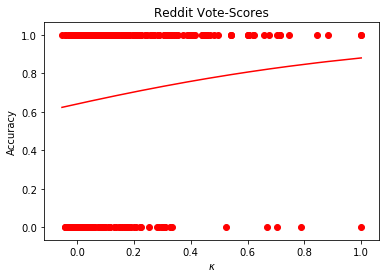

Reddit Vote-Scores
Logistic Regression: 1/e^−(0.58+1.4x)  R2:0.0255 p:0.0015




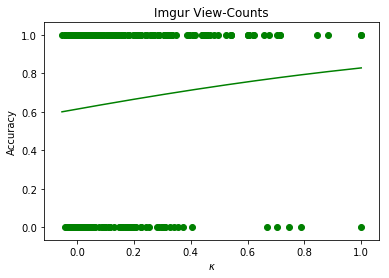

Imgur View-Counts
Logistic Regression: 1/e^−(0.46+1.1x)  R2:0.0163 p:0.0112




In [137]:
x_col ='fleiss_kappa'
for platform, colorP, acc_col in [('Reddit Vote-Scores','red','reddit_matches_preference_majority'),
               ('Imgur View-Counts','green','imgur_matches_preference_majority')]:
    pairs.sort_values(by=x_col,inplace=True)
    X = np.array(pairs[x_col])
    X = X.reshape(-1, 1)
    y = np.array(pairs[acc_col]) 
    LogR = LogisticRegression()
    LogR.fit(X, y)
    plt.figure()
    plt.scatter(X,y,color=colorP)
    x_vals = pairs[x_col] 
    line_x = np.array(x_vals) 
    line_x = line_x.reshape(-1, 1)
    logistic_yhat = [x[1] for x in LogR.predict_proba(line_x)]
    rval, p = stats.pearsonr(y,logistic_yhat)
    rsquared = rval * rval        
    plt.plot(line_x,logistic_yhat,color=colorP)
    plt.title(platform)
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'Accuracy') 
    plt.show() 
    print(platform)
    intercept,coef = LogR.intercept_[0], LogR.coef_[0][0]
    print('Logistic Regression: 1/e^−({}+{}x)  R2:{} p:{}\n\n'.format(round(intercept,2),
                                                    round(coef,1),round(rsquared,4),round(p,4)))
    
    

### Subreddit Effect

In [190]:
# accuracy by subreddit
for platform, colorP, acc_col in [('Reddit Vote-Scores','red','reddit_matches_preference_majority'),
               ('Imgur View-Counts','green','imgur_matches_preference_majority')]:
    pdat = pairs[pairs[x_col]>=0].copy()
    print(platform)
    for sr in set(pdat['subreddit']):
        mean, interval =mean_confidence_interval(pdat[pdat['subreddit']==sr][acc_col], confidence=0.95)
        print('\t',sr,'\n\t\t',round(100*mean,1), '% +-', round(interval*100,1))
        

Reddit Vote-Scores
	 EarthPorn 
		 71.4 % +- 13.1
	 OldSchoolCool 
		 64.0 % +- 13.8
	 photocritique 
		 68.0 % +- 13.4
	 CrappyDesign 
		 77.1 % +- 12.3
	 pics 
		 53.1 % +- 14.5
	 itookapicture 
		 82.0 % +- 11.0
	 funny 
		 64.0 % +- 13.8
	 aww 
		 64.6 % +- 14.0
Imgur View-Counts
	 EarthPorn 
		 69.4 % +- 13.4
	 OldSchoolCool 
		 68.0 % +- 13.4
	 photocritique 
		 64.0 % +- 13.8
	 CrappyDesign 
		 72.9 % +- 13.0
	 pics 
		 51.0 % +- 14.5
	 itookapicture 
		 76.0 % +- 12.3
	 funny 
		 62.0 % +- 13.9
	 aww 
		 54.2 % +- 14.6


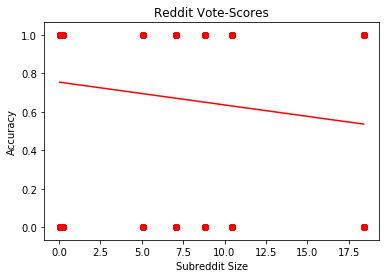

Reddit Vote-Scores
Linear Regression: -0.01x+0.75 R2:0.023 p:0.0025




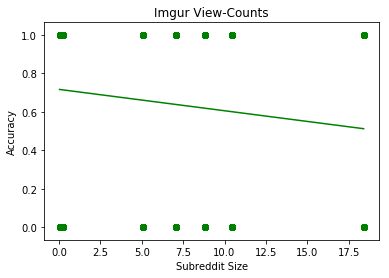

Imgur View-Counts
Linear Regression: -0.01x+0.72 R2:0.0193 p:0.0058




In [185]:
# accuracy as a function of subreddit size, correlation
x_col ='million_subscribers'
for platform, colorP, acc_col in [('Reddit Vote-Scores','red','reddit_matches_preference_majority'),
               ('Imgur View-Counts','green','imgur_matches_preference_majority')]:
    pdat = pairs[pairs[x_col]>=0].copy()
    pdat.sort_values(by=x_col,inplace=True)
    X = np.array(pdat[x_col])
    X = X.reshape(-1, 1)
    y = np.array(pdat[acc_col]) 
    LinR = LinearRegression()
    LinR.fit(X, y)
    plt.figure()
    plt.scatter(X,y,color=colorP)
    x_vals = pdat[x_col] 
    line_x = np.array(x_vals) 
    line_x = line_x.reshape(-1, 1)
    linear_yhat = [x for x in LinR.predict(line_x)]
    rval, p = stats.pearsonr(y,linear_yhat)
    rsquared = rval * rval        
    plt.plot(line_x,linear_yhat,color=colorP)
    plt.title(platform)
    plt.xlabel(r'Subreddit Size')
    plt.ylabel(r'Accuracy') 
    plt.show() 
    print(platform)
    intercept,coef = LinR.intercept_, LinR.coef_[0]
    print('Linear Regression: {}x+{} R2:{} p:{}\n\n'.format(round(coef,2),round(intercept,2),
                                        round(rsquared,4),round(p,4)))

    

### Image-Pair Score Balance Effect

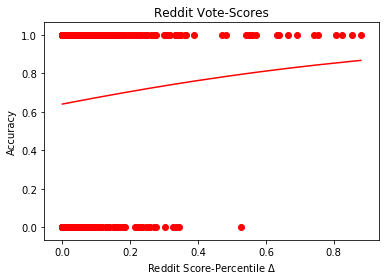

Reddit Vote-Scores
Logistic Regression: 1/e^−(0.58+1.5x)  R2:0.0201 p:0.0052




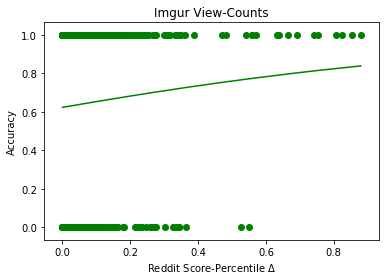

Imgur View-Counts
Logistic Regression: 1/e^−(0.5+1.3x)  R2:0.0162 p:0.0121




In [142]:
# accuracy by pair balance
# accuracy by delta score percentile difference, logistic regression, R2 and pvalue
x_col ='image_pair_percentile_diff'
for platform, colorP, acc_col in [('Reddit Vote-Scores','red','reddit_matches_preference_majority'),
               ('Imgur View-Counts','green','imgur_matches_preference_majority')]:
    pdat = pairs[pairs[x_col]>=0].copy()
    pdat.sort_values(by=x_col,inplace=True)
    X = np.array(pdat[x_col])
    X = X.reshape(-1, 1)
    y = np.array(pdat[acc_col]) 
    LogR = LogisticRegression()
    LogR.fit(X, y)
    plt.figure()
    plt.scatter(X,y,color=colorP)
    x_vals = pdat[x_col] 
    line_x = np.array(x_vals) 
    line_x = line_x.reshape(-1, 1)
    logistic_yhat = [x[1] for x in LogR.predict_proba(line_x)]
    rval, p = stats.pearsonr(y,logistic_yhat)
    rsquared = rval * rval        
    plt.plot(line_x,logistic_yhat,color=colorP)
    plt.title(platform)
    plt.xlabel(r'Reddit Score-Percentile $\Delta$')
    plt.ylabel(r'Accuracy') 
    plt.show() 
    print(platform)
    intercept,coef = LogR.intercept_[0], LogR.coef_[0][0]
    print('Logistic Regression: 1/e^−({}+{}x)  R2:{} p:{}\n\n'.format(round(intercept,2),
                                                    round(coef,1),round(rsquared,4),round(p,4)))
    
    

## Individual Player Ratings
### (individual players predicting platform outcome)

In [265]:
votes.columns

Index(['user_id', 'date_created', 'elapsed_time', 'subreddit', 'id',
       'image_pair', 'image_A', 'image_A_chosen', 'image_A_chosen_opinion',
       'image_A_quantile', 'image_A_imgur_views', 'image_A_score', 'image_B',
       'image_B_chosen', 'image_B_chosen_opinion', 'image_B_quantile',
       'image_B_imgur_views', 'image_B_score', 'image_A_percentile_label',
       'image_B_percentile_label', 'image_pair_label',
       'image_pair_percentile_diff', 'image_pair_percentile_diff_bin', 'q_id',
       'game_id', 'prediction_majority', 'preference_majority',
       'reddit_outcome', 'imgur_outcome', 'prop_select_prediction_majority',
       'prop_select_preference_majority', 'prop_select_reddit_outcome',
       'prop_select_imgur_outcome',
       'prediction_majority_matches_preference_majority',
       'reddit_matches_preference_majority',
       'reddit_matches_prediction_majority',
       'imgur_matches_preference_majority',
       'imgur_matches_prediction_majority', 'prediction_

In [ ]:
The results of this task were only slightly better than random guess:
personal preference accuracy was 54.0% with a 95% confidence interval of ± 0.8% and the player
prediction accuracy was 60.6% ± 0.6%.

In [267]:
# personal preference accuracy + 95% confidence interval
# player prediction accuracy + 95% confidence interval
# Overall accuracy + 95% confidence intervals
votes_with_pref2  =votes_with_pref[votes_with_pref['image_pair_percentile_diff']>=0]
for acc in ['image_A_chosen','image_A_chosen_opinion']:
    mean, interval = mean_confidence_interval(votes[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

for acc in ['image_A_chosen','image_A_chosen_opinion']:
    mean, interval = mean_confidence_interval(votes_with_pref[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )
for acc in ['image_A_chosen','image_A_chosen_opinion']:
    mean, interval = mean_confidence_interval(votes_with_pref2[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

for acc in ['preference_matches_prediction_majority','prediction_matches_preference_majority']:
    mean, interval = mean_confidence_interval(votes_with_pref[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

for acc in ['preference_matches_reddit','prediction_matches_reddit']:
    mean, interval = mean_confidence_interval(votes[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

for acc in ['preference_matches_reddit','prediction_matches_reddit']:
    mean, interval = mean_confidence_interval(votes_with_pref2[acc], confidence=0.95)
    print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )
    
for acc in ['preference_matches_imgur','prediction_matches_imgur']:
    mean, interval = mean_confidence_interval(votes[acc], confidence=0.95)
    #print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

for acc in ['preference_matches_imgur','prediction_matches_imgur']:
    mean, interval = mean_confidence_interval(votes_with_pref2[acc], confidence=0.95)
    #print( acc, '\t', round(100*mean,1), '% +-', round(interval*100,1) )

image_A_chosen 	 57.7 % +- 0.7
image_A_chosen_opinion 	 nan % +- nan
image_A_chosen 	 57.0 % +- 0.7
image_A_chosen_opinion 	 56.8 % +- 0.7
image_A_chosen 	 56.9 % +- 0.7
image_A_chosen_opinion 	 56.6 % +- 0.7
preference_matches_prediction_majority 	 60.4 % +- 0.7
prediction_matches_preference_majority 	 61.0 % +- 0.7
preference_matches_reddit 	 35.6 % +- 0.5
prediction_matches_reddit 	 56.5 % +- 0.5
preference_matches_reddit 	 56.1 % +- 0.7
prediction_matches_reddit 	 56.4 % +- 0.7


### Expertise Effect

In [162]:
survey_columns = ['frequency_of_use', 'length_of_use',
       'use_subreddit', 'browse_new_queue', 'vote_on_posts']

survey_votes = votes[votes['completed_survey']==1]

In [164]:
for q in survey_columns:
    print(q,'\n\t',Counter(survey_votes[q]))

frequency_of_use 
	 Counter({'Heavy': 12487, 'Casual': 7003, "Don't use it": 1385})
length_of_use 
	 Counter({'Over a year': 17493, ' 0-12 months ': 1988, "Don't use it": 1394})
use_subreddit 
	 Counter({'No': 11979, 'Yes': 5732, "Don't use it": 3164})
browse_new_queue 
	 Counter({'No': 16232, 'Yes': 2636, "Don't use it": 2007})
vote_on_posts 
	 Counter({'Yes': 13177, 'No': 6270, "Don't use it": 1428})


#### Accuracy by Survey Responses

In [234]:
survey_votes.columns

Index(['user_id', 'date_created', 'elapsed_time', 'subreddit', 'id',
       'image_pair', 'image_A', 'image_A_chosen', 'image_A_chosen_opinion',
       'image_A_quantile', 'image_A_imgur_views', 'image_A_score', 'image_B',
       'image_B_chosen', 'image_B_chosen_opinion', 'image_B_quantile',
       'image_B_imgur_views', 'image_B_score', 'image_A_percentile_label',
       'image_B_percentile_label', 'image_pair_label',
       'image_pair_percentile_diff', 'image_pair_percentile_diff_bin', 'q_id',
       'game_id', 'prediction_majority', 'preference_majority',
       'reddit_outcome', 'imgur_outcome', 'prop_select_prediction_majority',
       'prop_select_preference_majority', 'prop_select_reddit_outcome',
       'prop_select_imgur_outcome',
       'prediction_majority_matches_preference_majority',
       'reddit_matches_preference_majority',
       'reddit_matches_prediction_majority',
       'imgur_matches_preference_majority',
       'imgur_matches_prediction_majority', 'prediction_

In [247]:
print("Don't Use it vs all other responses as one group 'use'\n\n") 
for q in survey_columns:
    print(q)
    dontuse = survey_votes[survey_votes[q]=="Don't use it"]
    use = survey_votes[survey_votes[q]!="Don't use it"] 
     
    user_acc_use  = use.groupby('user_id',as_index=False)[pred_acc_cols+['image_A_chosen']].mean()
    user_acc_dontuse  = dontuse.groupby('user_id',as_index=False)[pred_acc_cols+['image_A_chosen']].mean() 
         
    mean, interval = mean_confidence_interval(user_acc_use['image_A_chosen'], confidence=0.95)
    mean_use = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )
    mean, interval = mean_confidence_interval(user_acc_dontuse['image_A_chosen'], confidence=0.95)
    mean_dontuse = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )

    t, pval = stats.ttest_ind(user_acc_use['image_A_chosen'], user_acc_dontuse['image_A_chosen']) 
    print("\t\tMean\t Use: {} \t Don't Use: {}".format(mean_use,mean_dontuse))
    print("\t\tTtest(Use,Dont Use): p-value: ",pval)

Don't Use it vs all other responses as one group 'use'


frequency_of_use
		Mean	 Use: 57.8% +-0.7 	 Don't Use: 56.5% +-3.1
		Ttest(Use,Dont Use): p-value:  0.35831362154475244
length_of_use
		Mean	 Use: 57.8% +-0.7 	 Don't Use: 56.4% +-3.0
		Ttest(Use,Dont Use): p-value:  0.32030836206473123
use_subreddit
		Mean	 Use: 57.7% +-0.7 	 Don't Use: 57.4% +-1.9
		Ttest(Use,Dont Use): p-value:  0.7664885343416736
browse_new_queue
		Mean	 Use: 57.8% +-0.7 	 Don't Use: 56.5% +-2.4
		Ttest(Use,Dont Use): p-value:  0.24661653796894667
vote_on_posts
		Mean	 Use: 57.8% +-0.7 	 Don't Use: 56.4% +-3.0
		Ttest(Use,Dont Use): p-value:  0.30831250093493084


#### Power Users

In [159]:
power_user_survey_votes = survey_votes[survey_votes['frequency_of_use']=='Heavy']
power_user_survey_votes = power_user_survey_votes[power_user_survey_votes['length_of_use']=='Over a year']

power_user_survey_votes = power_user_survey_votes[power_user_survey_votes['vote_on_posts']=='Yes']
power_user_survey_votes = power_user_survey_votes[power_user_survey_votes['browse_new_queue']=='Yes']

non_power_user_survey_votes = survey_votes[survey_votes['frequency_of_use']!='Heavy']
non_power_user_survey_votes = non_power_user_survey_votes[non_power_user_survey_votes['length_of_use']!='Over a year']
non_power_user_survey_votes = non_power_user_survey_votes[non_power_user_survey_votes['vote_on_posts']!='Yes']
non_power_user_survey_votes = non_power_user_survey_votes[non_power_user_survey_votes['browse_new_queue']!='Yes']

non_power_user_survey_votes_who_use_sr = non_power_user_survey_votes[non_power_user_survey_votes['use_subreddit']=='Yes']
non_power_user_survey_votes_who_dontuse_sr = non_power_user_survey_votes[non_power_user_survey_votes['use_subreddit']!='Yes']
power_user_surveys_who_use_sr = power_user_survey_votes[power_user_survey_votes['use_subreddit']=='Yes']


dontuse_user_survey_votes = survey_votes[survey_votes['frequency_of_use']=="Don't use it"]
dontuse_user_survey_votes = dontuse_user_survey_votes[dontuse_user_survey_votes['length_of_use']=="Don't use it"]
dontuse_user_survey_votes = dontuse_user_survey_votes[dontuse_user_survey_votes['vote_on_posts']=="Don't use it"]
dontuse_user_survey_votes = dontuse_user_survey_votes[dontuse_user_survey_votes['browse_new_queue']=="Don't use it"]
dontuse_user_survey_votes = dontuse_user_survey_votes[dontuse_user_survey_votes['use_subreddit']=="Don't use it"]

print(len(power_user_survey_votes),'votes by',len(set(power_user_survey_votes['user_id'])),'power users')
print(len(power_user_surveys_who_use_sr),'votes by',len(set(power_user_surveys_who_use_sr['user_id'])),
      'power users who use the subreddit surveyed.')
print(len(dontuse_user_survey_votes),'votes by',len(set(dontuse_user_survey_votes['user_id'])),
      'power users who dont use Reddit.')

1771 votes by 174 power users
591 votes by 60 power users who use the subreddit surveyed.
1189 votes by 121 power users who dont use Reddit.


In [245]:
survey_use_responses = {'frequency_of_use':['Heavy','Casual'], 
                        'length_of_use':['Over a year',' 0-12 months '],
                        'use_subreddit':['Yes','No'], 
                        'browse_new_queue':['Yes','No'], 
                        'vote_on_posts':['Yes','No']}
 
print('Power User Comparisons:\n')
for power_user_type, non_power_user_type, power_user_votes, non_power_user_votes in [
    ('power user','non-power user',power_user_survey_votes,non_power_user_survey_votes),
    ('power users who use subreddit','non-power user who *is* familiar with subreddit',
     power_user_surveys_who_use_sr,non_power_user_survey_votes_who_use_sr),
    ('power users who use subreddit','non-power user who is *not* familiar with subreddit',
     power_user_surveys_who_use_sr,non_power_user_survey_votes_who_dontuse_sr),
    ('power user','dont-use user',power_user_survey_votes,dontuse_user_survey_votes),
    ('power users who use subreddit','dont-use user',
     power_user_surveys_who_use_sr,dontuse_user_survey_votes) ]: 
    
    print(power_user_type, ' vs. ', non_power_user_type) 
    user_acc_PU = power_user_votes[power_user_votes['asked_for_preference']==1].groupby('user_id',as_index=False)[['image_A_chosen']].mean()
    user_acc_NPU = non_power_user_votes[non_power_user_votes['asked_for_preference']==1].groupby('user_id',as_index=False)[['image_A_chosen']].mean()
    
    
    for acc_col in ['image_A_chosen']:# pref_acc_cols: 
        mean, interval = mean_confidence_interval(user_acc_PU[acc_col], confidence=0.95)
        mean_PU = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )
        mean, interval = mean_confidence_interval(user_acc_NPU[acc_col], confidence=0.95)
        mean_NPU = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )

        t, pval = stats.ttest_ind(user_acc_PU[acc_col], user_acc_NPU[acc_col])  
        print("\tMean\t Power User: {} \t Not Power User: {}".format(mean_PU,mean_NPU))
        print("\tTtest(Power User,Not Power User) p-value: ",pval)

    user_acc_PU = power_user_votes.groupby('user_id',as_index=False)[['image_A_chosen']].mean()
    user_acc_NPU = non_power_user_votes.groupby('user_id',as_index=False)[['image_A_chosen']].mean() 
    for acc_col in ['image_A_chosen']:    
        mean, interval = mean_confidence_interval(user_acc_PU[acc_col], confidence=0.95)
        mean_PU = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )
        mean, interval = mean_confidence_interval(user_acc_NPU[acc_col], confidence=0.95)
        mean_NPU = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )

        t, pval = stats.ttest_ind(user_acc_PU[acc_col], user_acc_NPU[acc_col]) 
        print("\tMean\t Power User: {} \t Not Power User: {}".format(mean_PU,mean_NPU))
        print("\tTtest(Power User,Not Power User) p-value: ",pval)


Power User Comparisons:

power user  vs.  non-power user
	Mean	 Power User: 57.0% +-2.9 	 Not Power User: 54.8% +-2.6
	Ttest(Power User,Not Power User) p-value:  0.27324409681186185
	Mean	 Power User: 57.6% +-2.4 	 Not Power User: 56.4% +-2.3
	Ttest(Power User,Not Power User) p-value:  0.46533878172345544
power users who use subreddit  vs.  non-power user who *is* familiar with subreddit
	Mean	 Power User: 56.3% +-5.2 	 Not Power User: 44.9% +-4.9
	Ttest(Power User,Not Power User) p-value:  0.06319240972130456
	Mean	 Power User: 57.3% +-4.3 	 Not Power User: 46.4% +-5.0
	Ttest(Power User,Not Power User) p-value:  0.045710566563540465
power users who use subreddit  vs.  non-power user who is *not* familiar with subreddit
	Mean	 Power User: 56.3% +-5.2 	 Not Power User: 55.4% +-2.7
	Ttest(Power User,Not Power User) p-value:  0.7520294841803585
	Mean	 Power User: 57.3% +-4.3 	 Not Power User: 56.8% +-2.4
	Ttest(Power User,Not Power User) p-value:  0.8691340732560876
power user  vs.  dont-

In [263]:
survey_nonpower_user_responses = {'frequency_of_use':["Don't use it",'Casual'], 
                        'length_of_use':["Don't use it",' 0-12 months '],
                        'use_subreddit':["Don't use it",'Yes','No'], 
                        'browse_new_queue':["Don't use it",'No'], 
                        'vote_on_posts':["Don't use it",'No']}

for user_type, power_user_data, non_power_user_dataALL in [('power users (no sr use q)', 
                                                         power_user_survey_votes,
                                                         non_power_user_survey_votes),
                                                        ('power users who use sr surveyed', 
                                                         power_user_surveys_who_use_sr,
                                                         non_power_user_survey_votes_who_use_sr )]:

    for q in survey_columns:
        print(q, ' --- ', user_type)
        #print(survey_nonpower_user_responses[q])
        for survey_response in survey_nonpower_user_responses[q]: 
            print('\tnon-poweruser =',survey_response)
            non_power_user_data = non_power_user_dataALL[non_power_user_dataALL[q]==survey_response]
 
            user_acc_power_user = power_user_data.groupby('user_id',as_index=False)[['image_A_chosen']].mean()
            user_acc_non_power_user = non_power_user_data.groupby('user_id',as_index=False)[['image_A_chosen']].mean() 
            for acc_col in ['image_A_chosen']:  #pred_acc_cols:     
                mean, interval = mean_confidence_interval(user_acc_power_user[acc_col], confidence=0.95)
                mean_PU = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )
                mean, interval = mean_confidence_interval(user_acc_non_power_user[acc_col], confidence=0.95)
                mean_NPU = str( round(100*mean,1) )+ '% +-'+ str( round(interval*100,1) )

                t, pval = stats.ttest_ind(user_acc_power_user[acc_col], user_acc_non_power_user[acc_col]) 
                print("\tMean\t Power User: {} \t Non-Power User: {}".format(mean_PU,mean_NPU))
                print("\tTtest for {}(Power User,{}) \tp-value={}\n".format(q,survey_response,pval)) 

                

frequency_of_use  ---  power users (no sr use q)
	non-poweruser = Don't use it
	Mean	 Power User: 57.6% +-2.4 	 Non-Power User: 56.5% +-3.1
	Ttest for frequency_of_use(Power User,Don't use it) 	p-value=0.5828527061897624

	non-poweruser = Casual
	Mean	 Power User: 57.6% +-2.4 	 Non-Power User: 56.1% +-3.2
	Ttest for frequency_of_use(Power User,Casual) 	p-value=0.4737511855294996

length_of_use  ---  power users (no sr use q)
	non-poweruser = Don't use it
	Mean	 Power User: 57.6% +-2.4 	 Non-Power User: 56.6% +-3.1
	Ttest for length_of_use(Power User,Don't use it) 	p-value=0.6038689977352185

	non-poweruser =  0-12 months 
	Mean	 Power User: 57.6% +-2.4 	 Non-Power User: 55.9% +-3.3
	Ttest for length_of_use(Power User, 0-12 months ) 	p-value=0.44437903712716653

use_subreddit  ---  power users (no sr use q)
	non-poweruser = Don't use it
	Mean	 Power User: 57.6% +-2.4 	 Non-Power User: 56.4% +-3.1
	Ttest for use_subreddit(Power User,Don't use it) 	p-value=0.5577084182404215

	non-powerus

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


### Effort Effect

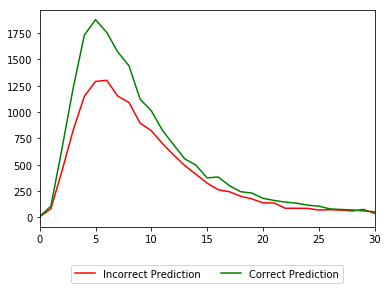

In [223]:
# response time distributions
judgement_col = 'image_A_chosen'
votes['n_responses'] = [1]*len(votes)
pltdat = votes.groupby([judgement_col,'response_time_bin'],as_index=False)[['n_responses']].count()
for hueColVal, hueColor, lab in [(0,'red','Incorrect Prediction'),
                            (1,'green','Correct Prediction')]:
    hueData = pltdat[pltdat[judgement_col]==hueColVal] 
    plt.plot(hueData['response_time_bin'],hueData['n_responses'],
             color=hueColor,label=lab)
plt.xlim(0,30)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2) 
plt.show()

In [202]:
# t test between correct and incorrect
print('\n\nT-Test')
delayres = pd.DataFrame(columns=['comparing','T', 'pvalue','mean (correct)','mean (incorrect)','median (correct)','median (incorrect)'])
for votedata in [votes,votes_with_pref]:
    for player_predictor_col in player_predictors:
        x = votedata[votedata[player_predictor_col]==1]['elapsed_time']
        y = votedata[votedata[player_predictor_col]==0]['elapsed_time']
        t, pval = stats.ttest_ind(x, y) 
        mean_corr, mean_incorr = np.mean(x), np.mean(y)
        median_corr, median_incorr = np.median(x), np.median(y)
        delayres.loc[len(delayres)]=[player_predictor_col,t, pval, mean_corr, mean_incorr, median_corr, median_incorr]
print(delayres)  


# correlation of accuracy to response time, R2 and pvalue
print('\n\nCorrelation\n')
votes.loc[:,'response_time_bin'] = [math.ceil(x) for x in votes['elapsed_time']]
for player_predictor_col in player_predictors:
    print(player_predictor_col)
    response_time_acc = votes.groupby('response_time_bin',as_index=False)[[player_predictor_col]].mean()
    rval, p = stats.pearsonr(response_time_acc['response_time_bin'], response_time_acc[player_predictor_col])
    rsquared = rval * rval
    m, b, rLR, pLR, std_err = stats.linregress(response_time_acc['response_time_bin'],
                                               response_time_acc[player_predictor_col])
    rsquared2 = rLR * rLR
    titleVal = ' pearsonR='+str(round(rval,4))+' R2='+ str(round(rsquared,4)) + ' p='+str(round(p,4)) 
    titleVal = titleVal + '\ny='+str(round(m,15))+'*x +'+str(round(b,6))+'};% ('
    titleVal = titleVal + str(round(rsquared2,3))+','+str(round(pLR,4))+')\n'
    print(titleVal)



T-Test
                                comparing      T  pvalue  mean (correct)  mean (incorrect)  median (correct)  median (incorrect)
0  prediction_matches_preference_majority -0.808   0.419          21.992            26.200               8.0                 8.0
1  preference_matches_preference_majority  0.306   0.760          24.375            22.819               8.0                 8.0
2  prediction_matches_preference_majority -0.760   0.447          26.011            32.116               9.0                10.0
3  preference_matches_preference_majority -0.656   0.512          26.487            31.864               9.0                 9.0


Correlation

prediction_matches_preference_majority
 pearsonR=-0.032 R2=0.001 p=0.5398
y=-3.114333973e-06*x +0.590455};% (0.001,0.5398)

preference_matches_preference_majority
 pearsonR=-0.0193 R2=0.0004 p=0.7113
y=-1.873351049e-06*x +0.573682};% (0.0,0.7113)



## Reddit Score Percentile Differences and Agreement

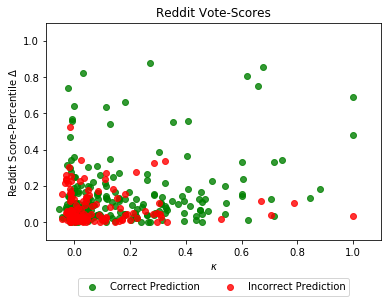

In [58]:
# Reddit Score Percentile Differences as a function of fleiss kappa (k)

sns.regplot(x='fleiss_kappa',y='image_pair_percentile_diff',
           data=pairs[pairs['reddit_matches_preference_majority']==1],
            label='Correct Prediction',fit_reg=False,scatter_kws={"color": "green"})
sns.regplot(x='fleiss_kappa',y='image_pair_percentile_diff',
           data=pairs[pairs['reddit_matches_preference_majority']==0],
            label='Incorrect Prediction',fit_reg=False,scatter_kws={"color": "red"})
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'Reddit Score-Percentile $\Delta$')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.title('Reddit Vote-Scores')
